### Library Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sktime



from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)

from sktime.utils import plotting


from sklearn.linear_model import (
    LinearRegression,
    ElasticNetCV,
    MultiTaskElasticNetCV,
    MultiTaskElasticNet,
    RidgeCV,
    LassoCV,
    HuberRegressor,
)

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [4]:
corr = dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.135391,-0.094852,-0.016158,-0.282037,0.028211,-0.053270
dewp,0.135391,1.000000,0.906020,-0.801776,-0.334133,-0.055574,0.176558
temp,-0.094852,0.906020,1.000000,-0.865277,-0.217490,-0.133997,0.093423
press,-0.016158,-0.801776,-0.865277,1.000000,0.214193,0.101694,-0.113859
wnd_spd,-0.282037,-0.334133,-0.217490,0.214193,1.000000,0.019842,-0.007890
snow,0.028211,-0.055574,-0.133997,0.101694,0.019842,1.000000,-0.014704
rain,-0.053270,0.176558,0.093423,-0.113859,-0.007890,-0.014704,1.000000


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB


ADF Test Statistic: -9.928484458237602
p-value: : 2.864513016541384e-17
The Series is  stationary, as P value 2.864513016541384e-17 < 0.05


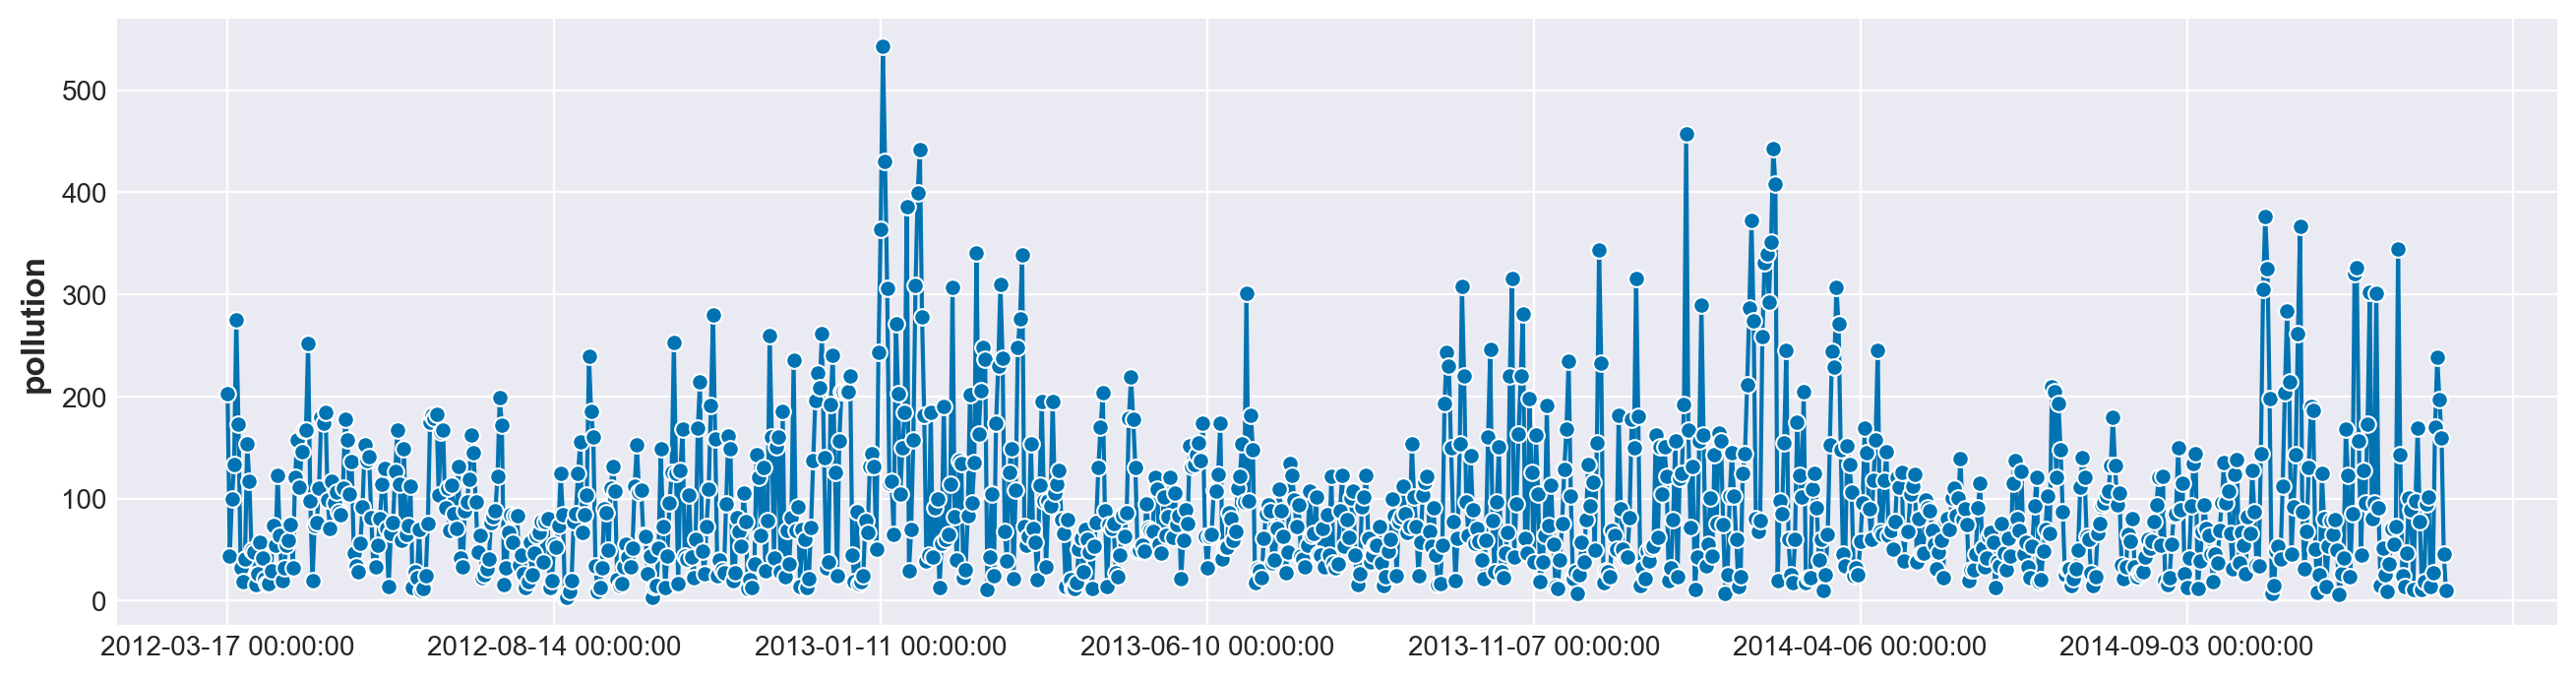

In [7]:
from statsmodels.tsa.stattools import adfuller

TEST_SIZE = 30
TARGET_COl = 'pollution'

plotting.plot_series(dataframe.tail(1020)[TARGET_COl])


adf_result = adfuller(dataframe[TARGET_COl])

print(f"ADF Test Statistic: {adf_result[0]}")
print(f"p-value: : {adf_result[1]}")

if adf_result[1] > 0.05 :
    print(f'The Series is non stationary, as P value {adf_result[1]} > 0.05')
else:
    print(f'The Series is  stationary, as P value {adf_result[1]} < 0.05')

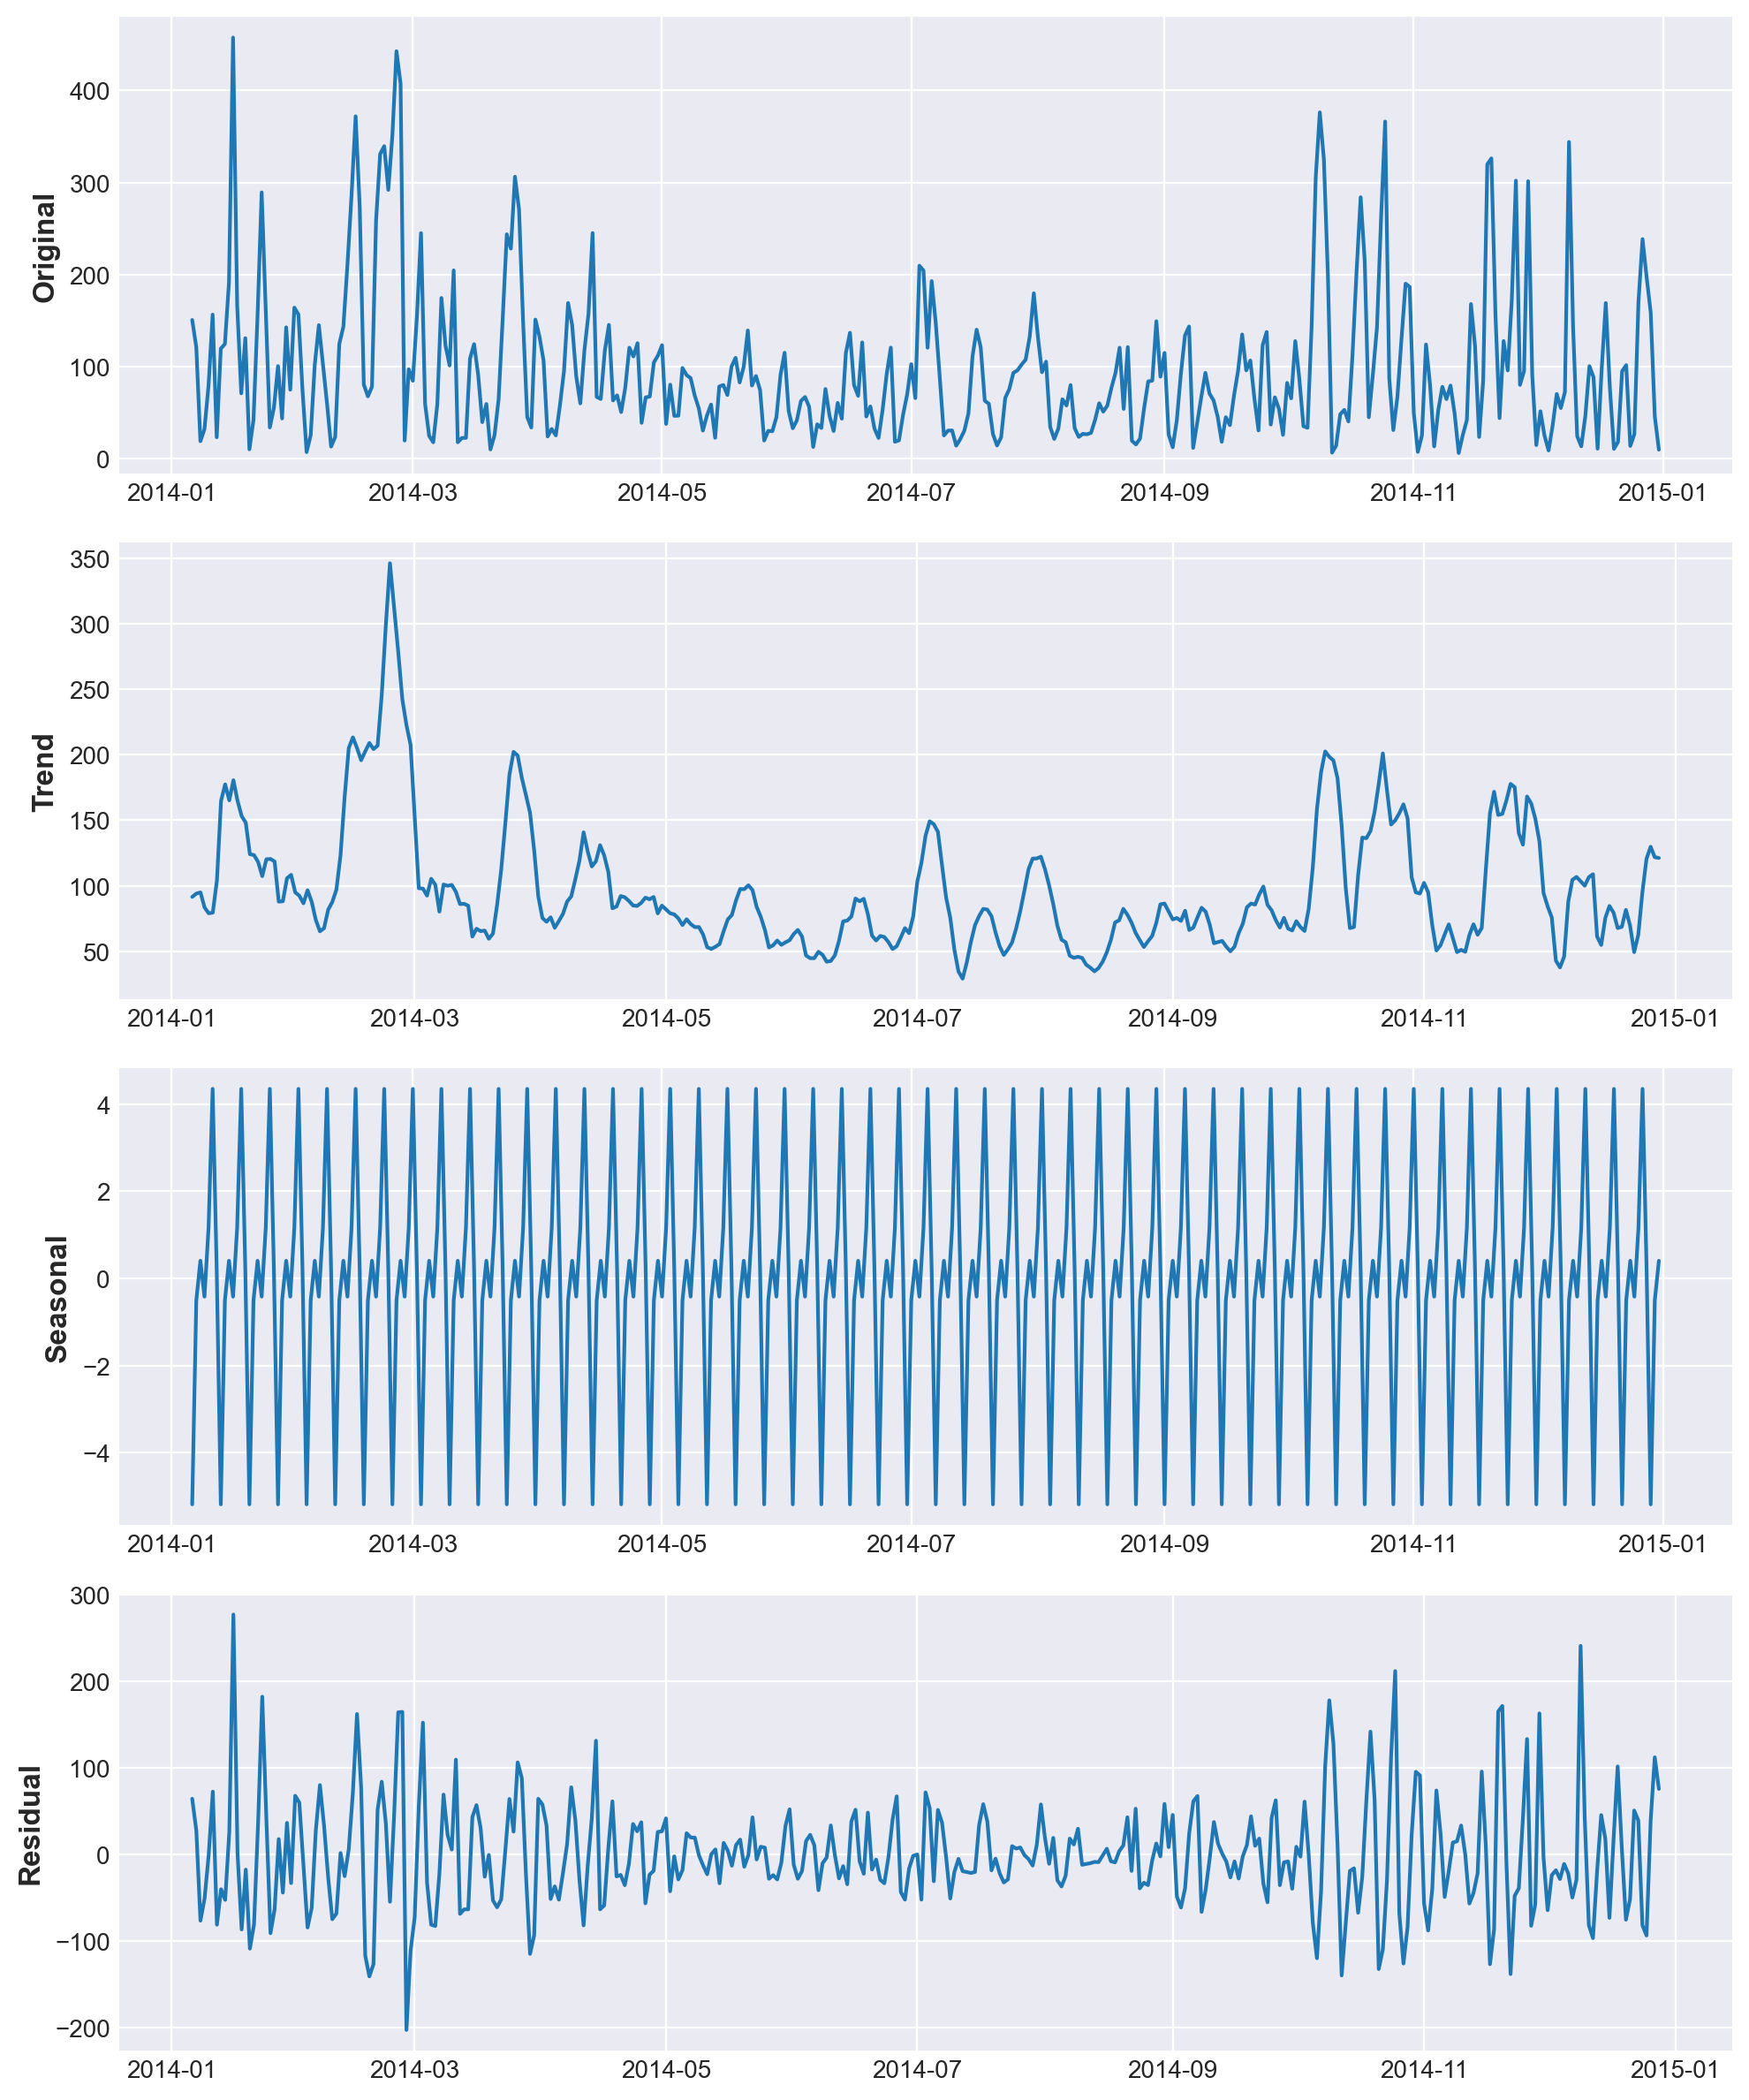

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose 

ts_dicomposition = seasonal_decompose(x=dataframe[TARGET_COl], model='additive')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

n=360
# Original time series
ax1.plot(dataframe[TARGET_COl].tail(n))
ax1.set_ylabel('Original')
# Trend component
ax2.plot(ts_dicomposition.trend.tail(n))
ax2.set_ylabel('Trend')
# Seasonal component
ax3.plot(ts_dicomposition.seasonal.tail(n))
ax3.set_ylabel('Seasonal')
# Residual component
ax4.plot(ts_dicomposition.resid.tail(n))
ax4.set_ylabel('Residual')
# Adjust layout and display the plot
plt.tight_layout()
plt.show()


train_xy and test_xy size  Test_Train Split: (1795, 7), (30, 7)

y_train and x_train size after Target Seperation: (1795,), (1795, 6)
y_test  and x_test  size after Target Seperation: (30,),  (30, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

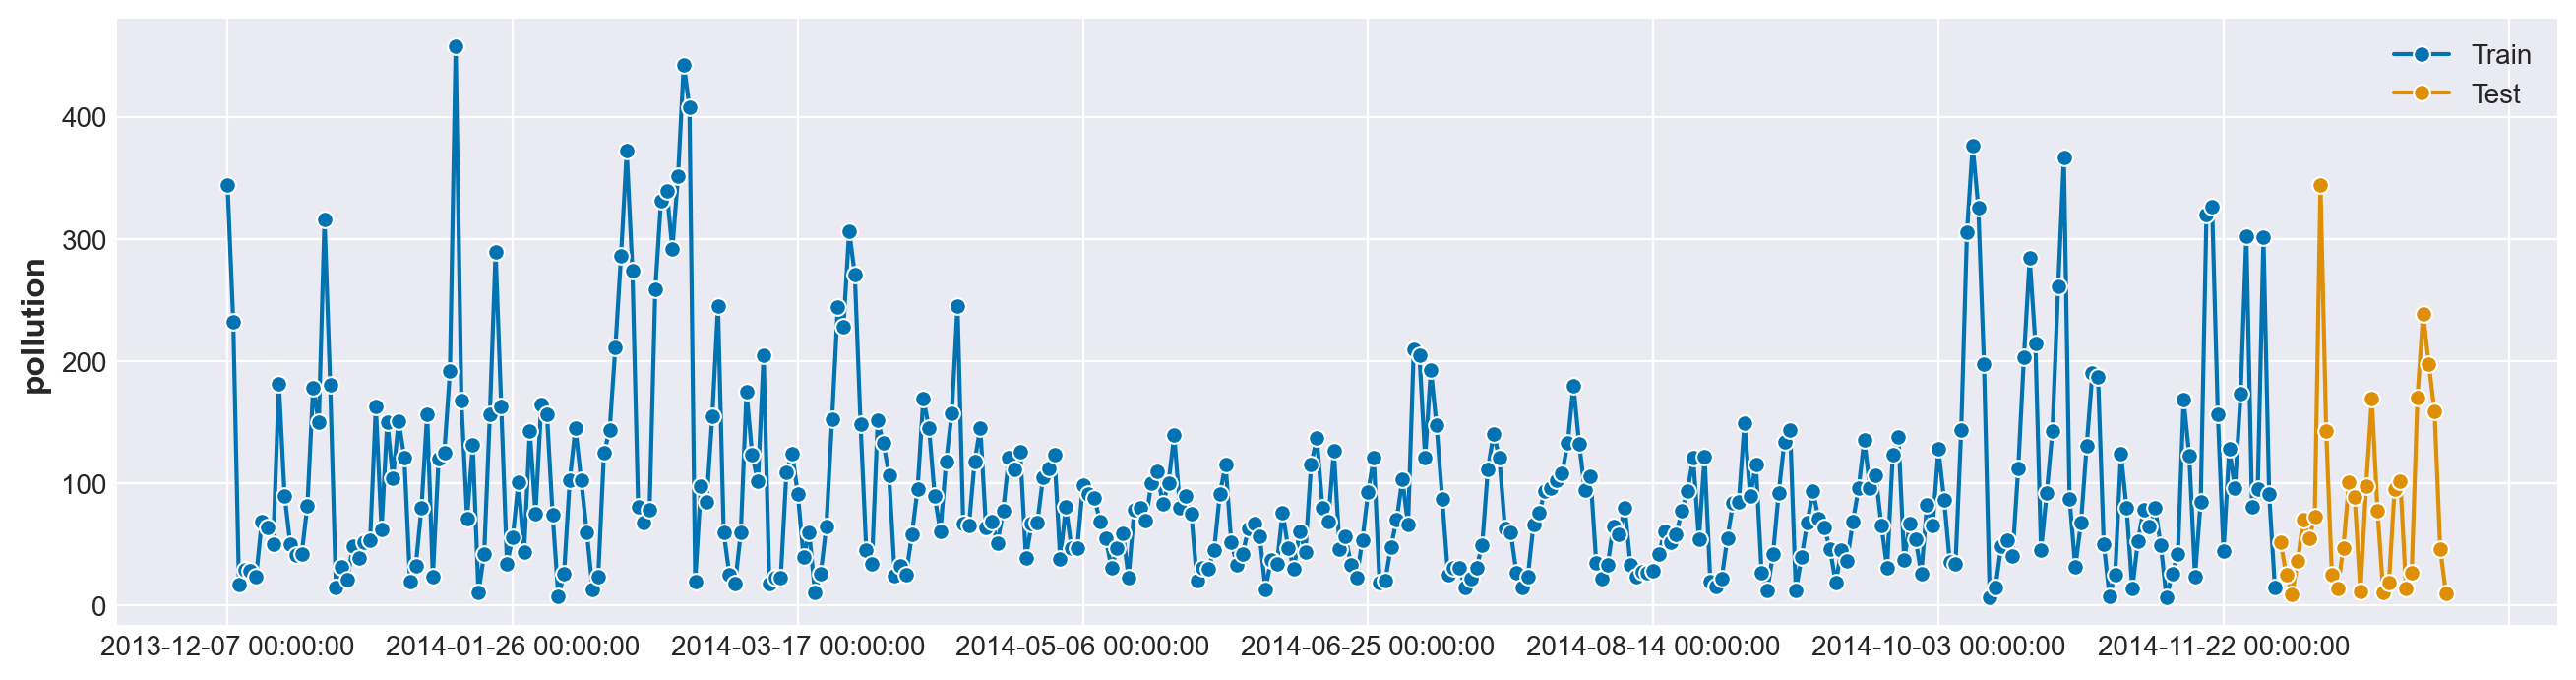

In [8]:
from sktime.utils import plotting
from sktime.forecasting.model_selection import temporal_train_test_split


train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)
print(f"train_xy and test_xy size  Test_Train Split: {train_xy.shape}, {test_xy.shape}", end='\n\n')

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train =  train_xy.drop(columns=[TARGET_COl]).copy(deep=True) 

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test =  test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size after Target Seperation: {y_train.shape}, {x_train.shape}")
print(f"y_test  and x_test  size after Target Seperation: {y_test.shape},  {x_test.shape}", end='\n\n')

plotting.plot_series(y_train.tail(360), y_test , labels=['Train','Test'])

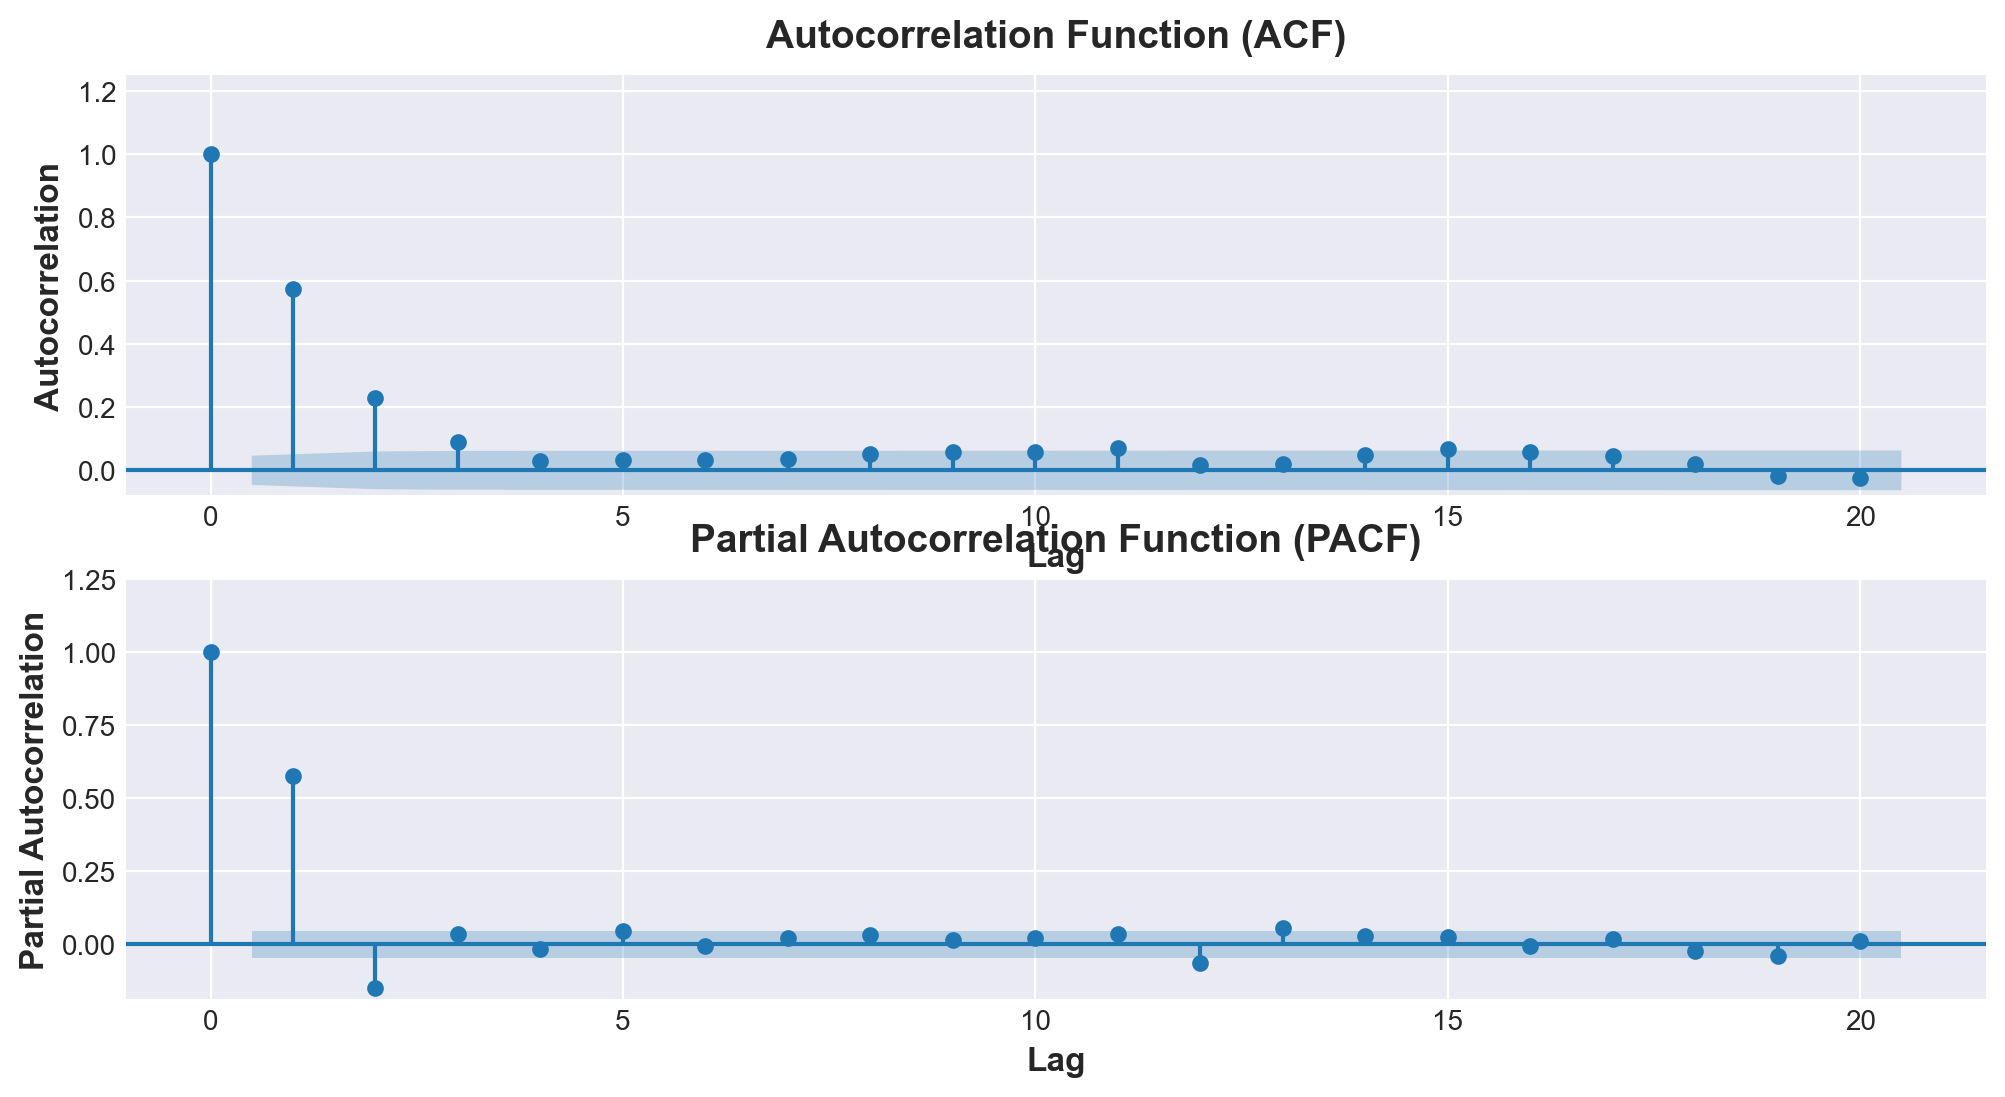

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(12,6))
plot_acf(y_train, ax=ax[0],lags=20, auto_ylims=True)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_train, ax=ax[1], lags=20, auto_ylims=True)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19201.729, Time=3.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20017.207, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19216.041, Time=2.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19344.437, Time=2.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20015.216, Time=0.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19198.993, Time=3.43 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=19203.891, Time=2.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=19196.274, Time=5.19 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19201.097, Time=4.04 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=18958.471, Time=10.87 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=19198.114, Time=6.05 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=18959.172, Time=13.34 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=18957.093, Time=11.40 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18965.648, Time=10.66 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=18953.873, Time=13.71 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=15.65 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.80 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=12.31 sec

Best model:  ARIMA(5,0,2)(0,0,0)[0] intercept
Total fit time: 132.499 seconds
MSE : 2922.008977124
RMSE: 54.055610043028835
MAE : 33.79346114802118
MAPE: 0.6999734620918082



C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

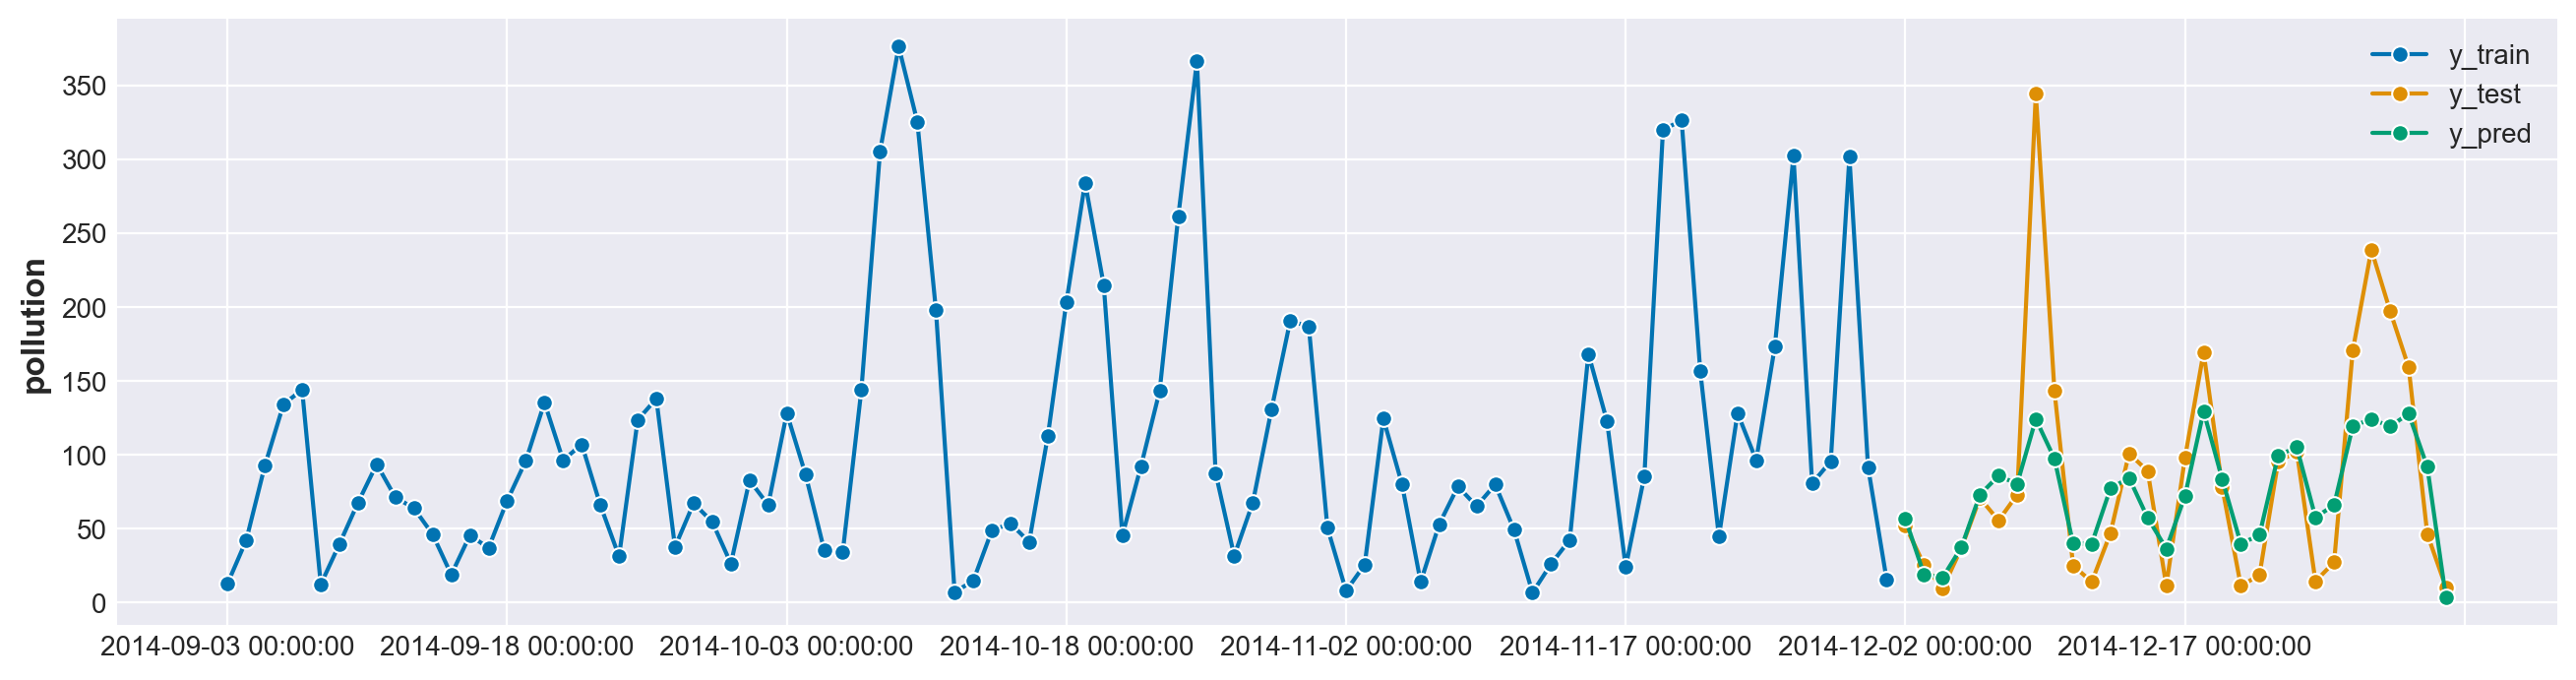

In [10]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor



mse  = MeanSquaredError(multioutput="uniform_average")
rmse = MeanSquaredError(square_root=True, multioutput='uniform_average')
mae  = MeanAbsoluteError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='uniform_average')


fh=np.arange(1, 31)

forecaster_pipe = AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200)

forecaster_pipe.fit(y_train, x_train)
y_pred = forecaster_pipe.predict(fh, X=x_test)

print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')

plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


#Best model:  ARIMA(5,0,2)(0,0,0)[0] intercept
#Total fit time: 131.637 seconds
#MSE : 2922.008977124
#RMSE: 54.055610043028835
#MAE : 33.79346114802118
#MAPE: 0.6999734620918082

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5595.201, Time=2.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6330.188, Time=0.92 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5604.612, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5749.510, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6346.386, Time=2.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5586.508, Time=2.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5588.808, Time=2.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5581.683, Time=3.92 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5581.613, Time=3.51 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=5314.931, Time=10.22 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=5268.245, Time=12.88 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=5311.884, Time=13.88 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=5374.794, Time=11.46 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=5356.856, Time=9.74 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 77.113 seconds
MSE : 4950.785175890659
RMSE: 70.36181617817053
MAE : 43.42691155015576
MAPE: 0.4687465644799563



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

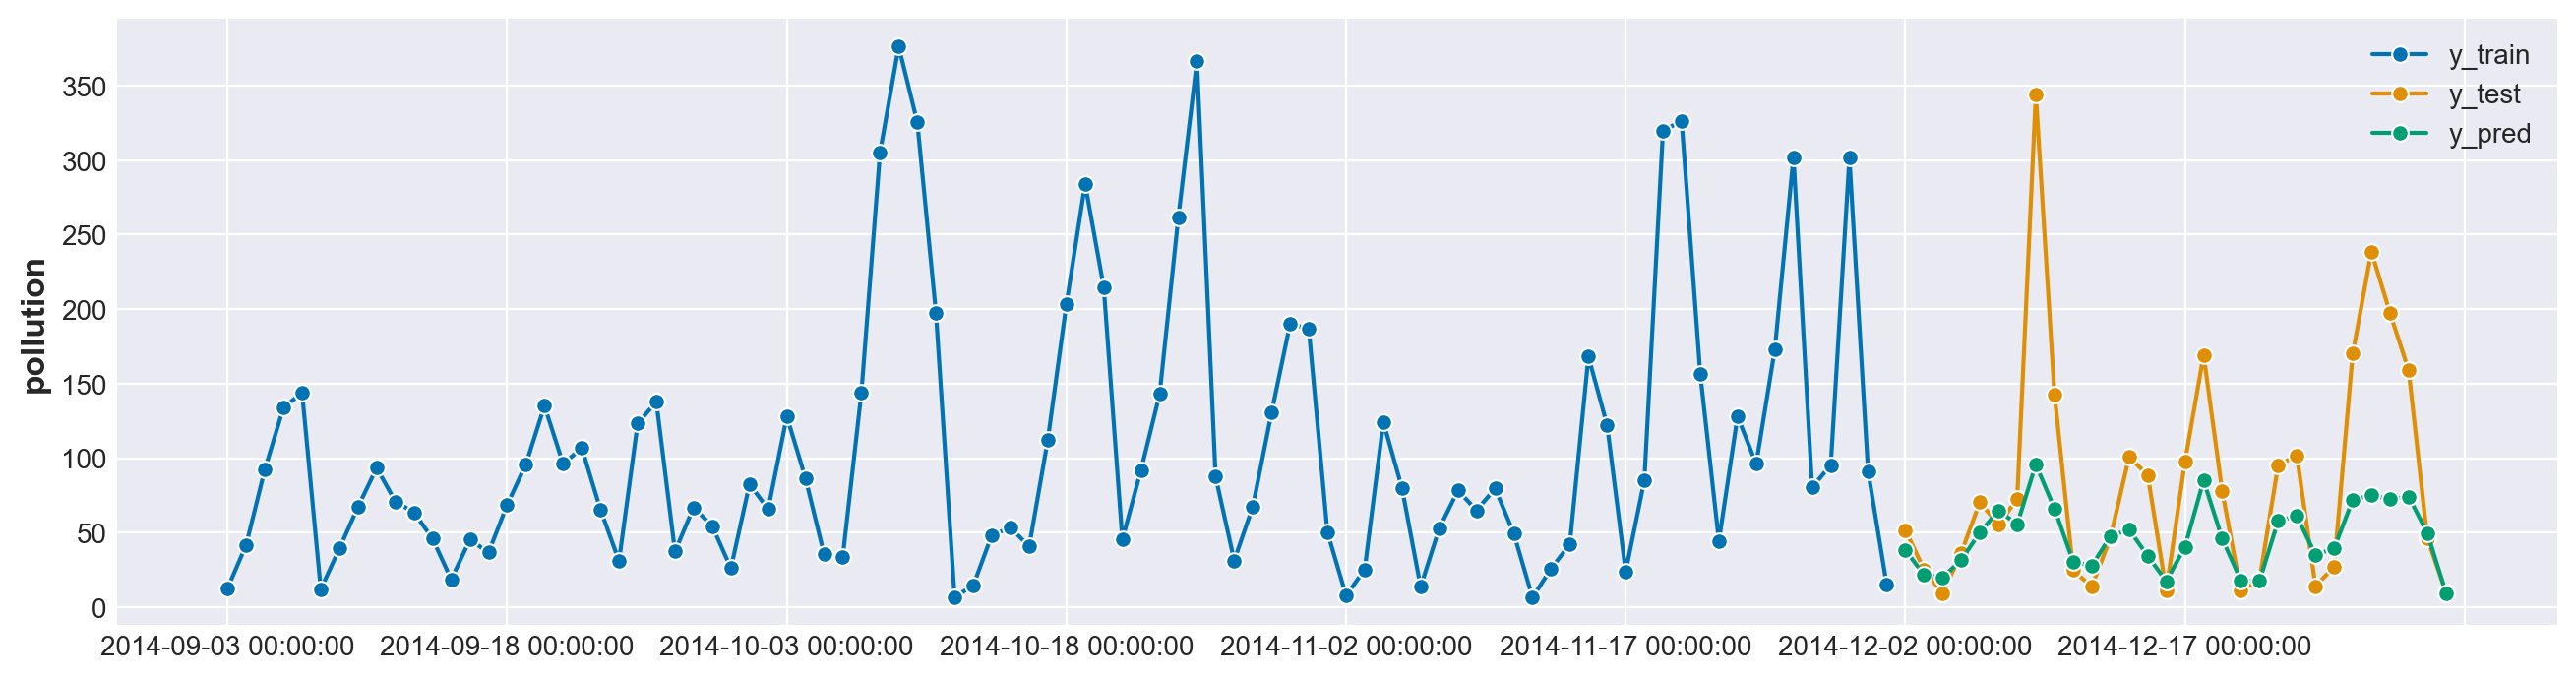

In [19]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor




fh=np.arange(1, 31)

forecaster_pipe = TransformedTargetForecaster(
    [
        ("trnsformer", BoxCoxTransformer()),
        ("forecaster", AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200) )
    ]
)

#forecaster_pipe = AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200)

forecaster_pipe.fit(y_train, x_train)
y_pred = forecaster_pipe.predict(fh, X=x_test)

print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')

plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19192.177, Time=4.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20007.048, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19206.903, Time=3.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19335.602, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20005.060, Time=1.43 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19189.940, Time=3.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=19194.255, Time=6.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=19186.937, Time=5.75 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19191.623, Time=6.70 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=18955.302, Time=10.52 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=19188.482, Time=5.98 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=18956.116, Time=13.43 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=18953.494, Time=11.75 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18962.266, Time=10.86 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=18950.796, Time=13.23 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=15.89 sec


C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=11.82 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=12.95 sec

Best model:  ARIMA(5,0,2)(0,0,0)[0] intercept
Total fit time: 139.611 seconds
MSE : 2841.0935338426834
RMSE: 53.30190928890525
MAE : 33.790860035876484
MAPE: 0.7445917463573549



C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

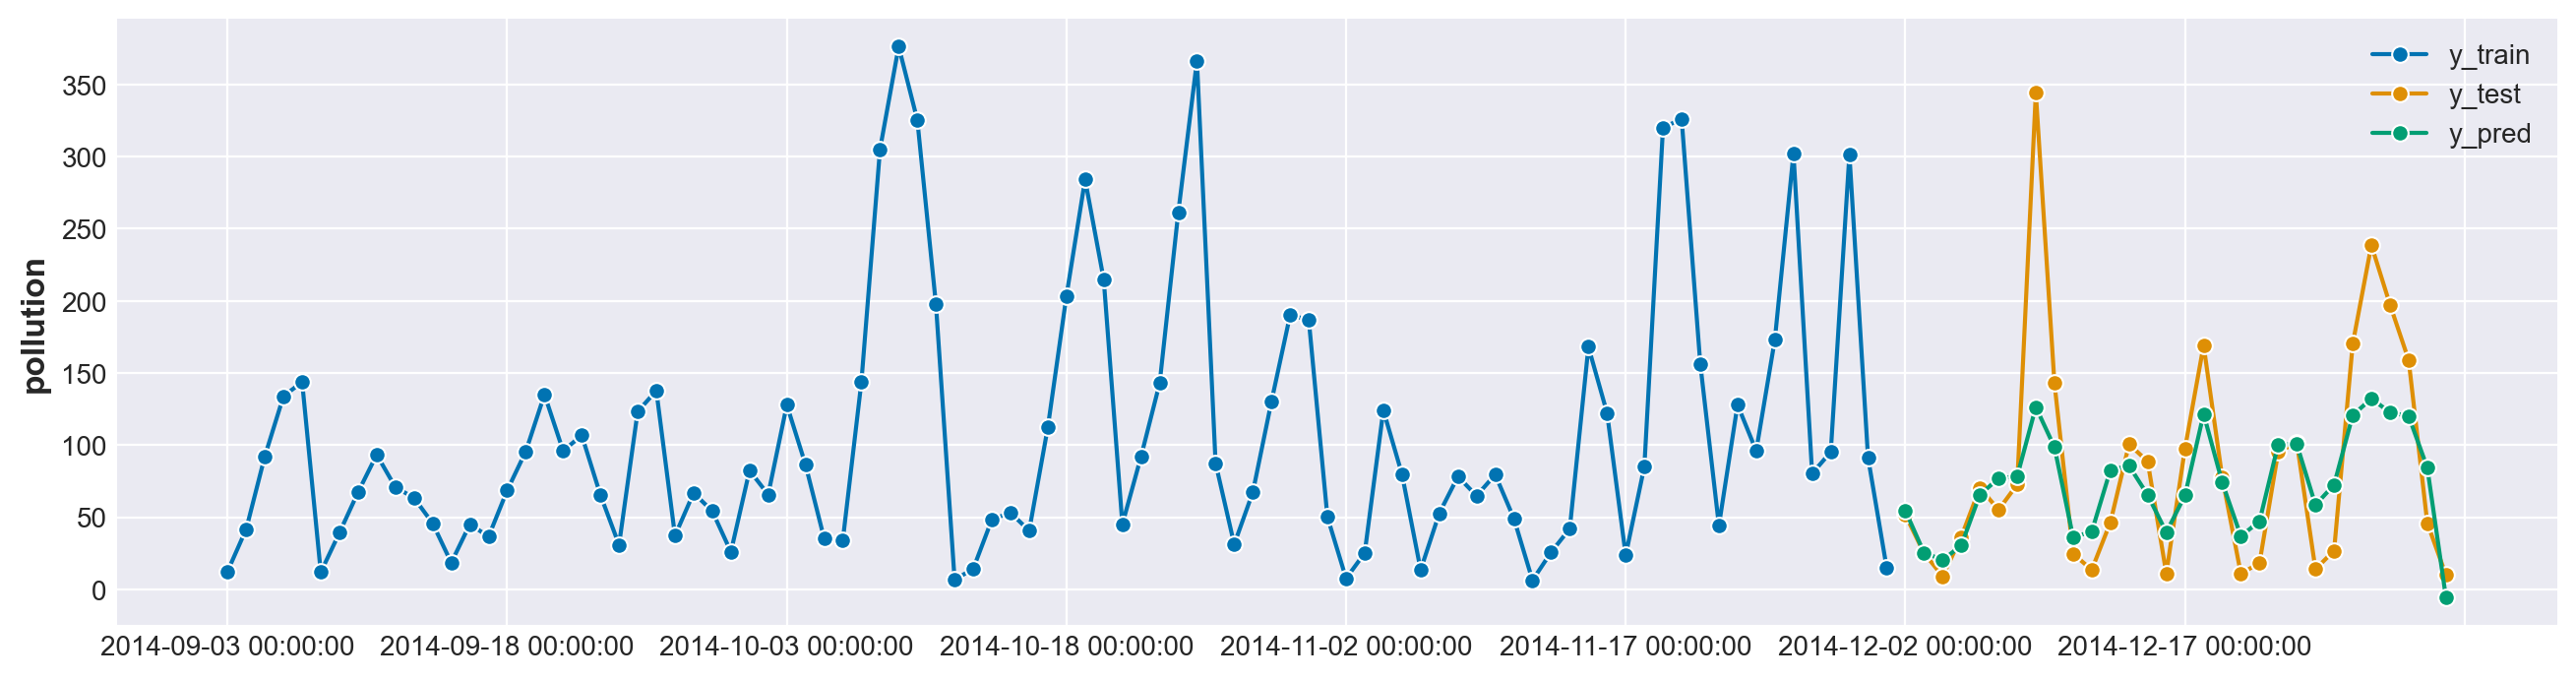

In [23]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import  Detrender, Deseasonalizer



fh=np.arange(1, 31)

forecaster_pipe = TransformedTargetForecaster(
    [
        ("detrend", Detrender()),
        ("deseasonalize_3M", Deseasonalizer(model="additive", sp=3)),
        ("deseasonalize_12M", Deseasonalizer(model="additive", sp=12)),
        ("forecaster", AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200) )
    ]
)

#forecaster_pipe = AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200)

forecaster_pipe.fit(y_train, x_train)
y_pred = forecaster_pipe.predict(fh, X=x_test)

print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')

plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


### Forcasting all Columns single step [ Ignore]

MSE : 5247.049893020225
RMSE: 72.43652319804026
MAE : 55.16259726813064
MAPE: 1.7886952097523914



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

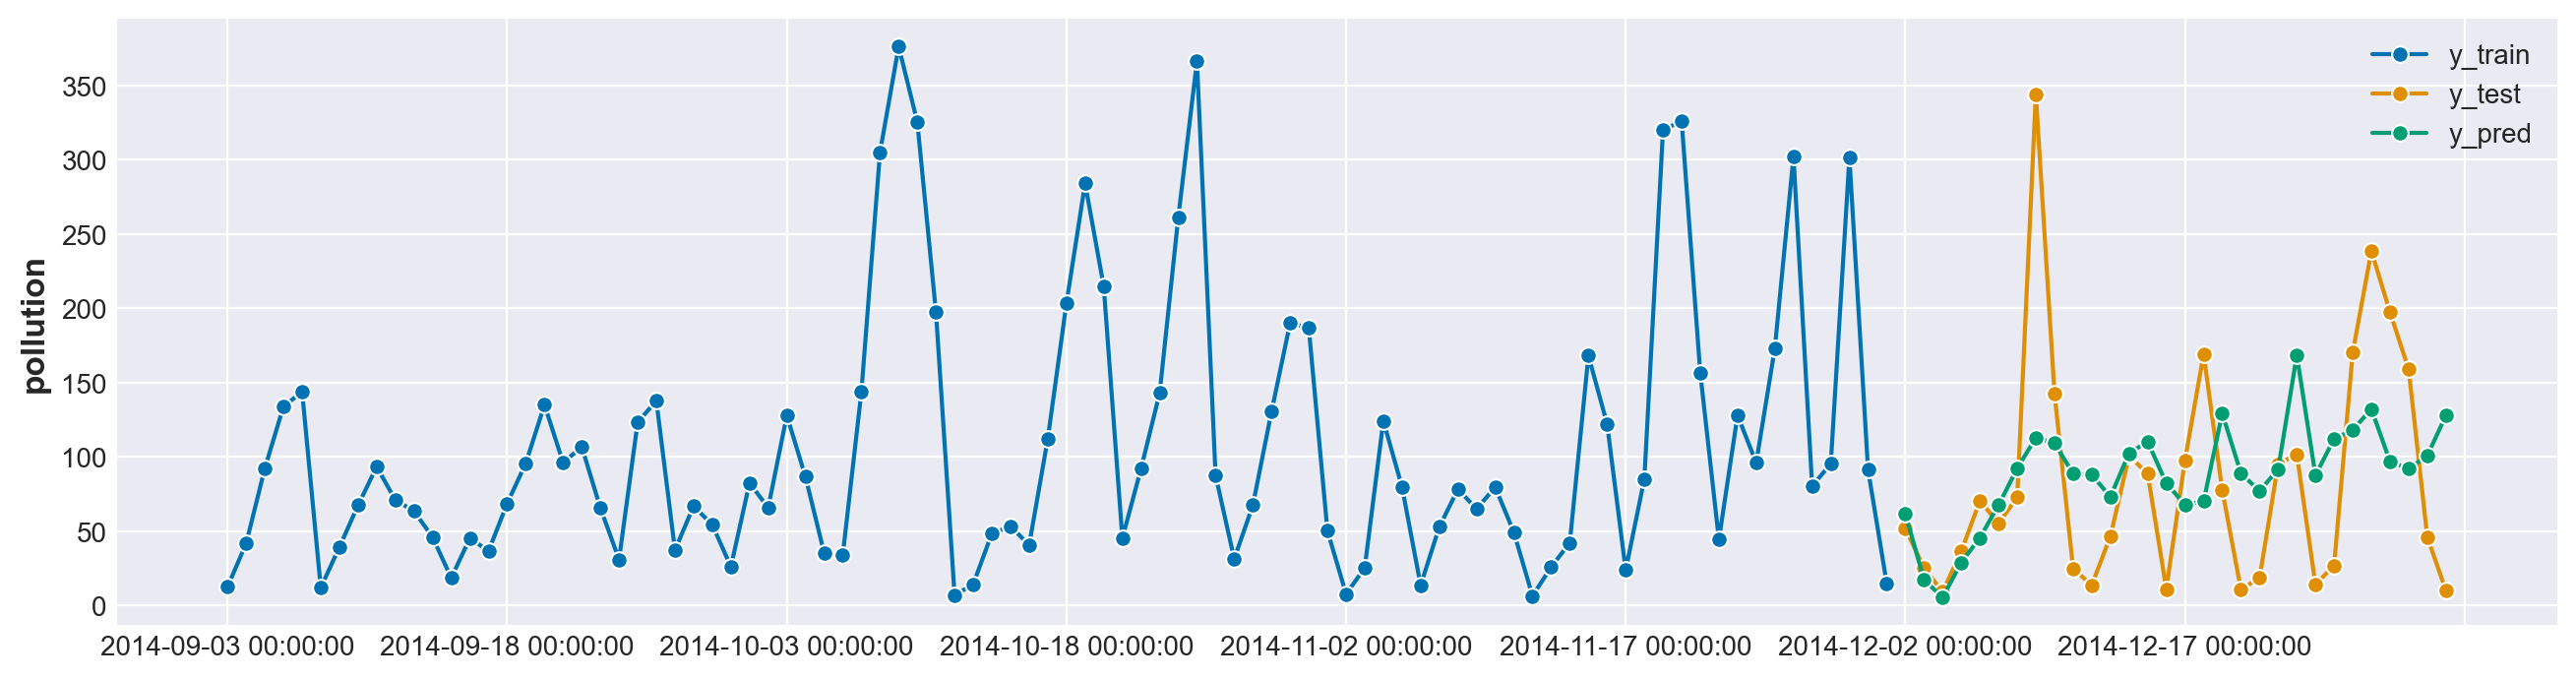

In [41]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor



mse  = MeanSquaredError(multioutput="uniform_average")
rmse = MeanSquaredError(square_root=True, multioutput='uniform_average')
mae  = MeanAbsoluteError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='uniform_average')



fh=np.arange(1, 31)

forecaster_pipe = ForecastingPipeline(
    [  
        ("scale_X", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster",  AutoARIMA(start_p=1,max_p=7, start_q=1,random_state=80, trace=True, maxiter=200))
    ])

forecaster_pipe = AutoARIMA(start_p=1, start_q=1,random_state=80, trace=True, maxiter=200)

forecaster_pipe.fit(y_train, x_train)
y_pred = forecaster_pipe.predict(fh, X=x_test)

print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')

plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


#Best model:  ARIMA(5,0,2)(0,0,0)[0] intercept
#Total fit time: 131.637 seconds
#MSE : 2922.008977124
#RMSE: 54.055610043028835
#MAE : 33.79346114802118
#MAPE: 0.6999734620918082